## Chapter Two

In [1]:
from fastai.vision.all import *

### Loading the Data

In [2]:
# downloading and unpacking the files
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
# setting the base path for convenience
Path.BASE_PATH = path

In [4]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [5]:
# inspect the mnist dataset
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [6]:
# load the files
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [7]:
# inspect one image
img3_path = threes[1]
img3 = Image.open(img3_path)
img3

In [8]:
array(img3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
# doing the same with a tensor
tensor(img3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [10]:
img3_t = tensor(img3)
df = pd.DataFrame(img3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


### Building a Baseline - Pixel Similarity

In [11]:
# load all the tensors
three_tensors = [tensor(Image.open(i)) for i in threes]
seven_tensors = [tensor(Image.open(i)) for i in sevens]
len(three_tensors), len(seven_tensors)

(6131, 6265)

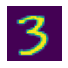

In [12]:
# use fastai function to display tensor as image
show_image(three_tensors[1]);

In [13]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

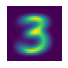

In [14]:
# calculate the mean over axis 0
three_mean = stacked_threes.mean(0)
show_image(three_mean);

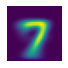

In [15]:
# also plot ideal seven
seven_mean = stacked_sevens.mean(0)
show_image(seven_mean);

Two ways of measuring distance in this context:
* Take the mean of the absolute value of differences (absolute value is the function that replaces negative values with positive values). This is called the mean absolute difference or L1 norm
* Take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). This is called the root mean squared error (RMSE) or L2 norm.

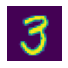

In [16]:
# take a sample three
three_sample = stacked_threes[2].float()
show_image(three_sample);

In [17]:
# calculate l1 norm to both means
l1_dist_3 = (three_sample-three_mean).abs().mean()
l1_dist_7 = (three_sample-seven_mean).abs().mean()
l1_dist_3, l1_dist_7

(tensor(0.1100), tensor(0.1541))

With l1 norm our sample image is closer to the ideal three which confirms our model.

In [18]:
# calculate l2 norm to both means
l2_dist_3 = ((three_sample-three_mean)**2).mean().sqrt()
l2_dist_7 = ((three_sample-seven_mean)**2).mean().sqrt()
l2_dist_3, l2_dist_7 

(tensor(0.1980), tensor(0.2974))

Also with the l2 norm our sample is closer to the ideal three which makes sense.

In [19]:
# there would be also pytorch function for these two losses
F.l1_loss(three_sample, three_mean), F.mse_loss(three_sample, three_mean).sqrt()

(tensor(0.1100), tensor(0.1980))

### Validating our Baseline Model

In [20]:
# loading the validation sets
valid_3_tensors = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'3').ls()])
valid_3_tensors = valid_3_tensors.float()/255
valid_7_tensors = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'7').ls()])
valid_7_tensors = valid_7_tensors.float()/255
valid_3_tensors.shape, valid_7_tensors.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [21]:
# creating our distance function
def mnist_distance(a, b): return (a-b).abs().mean((-1, -2))
mnist_distance(three_sample, three_mean)

tensor(0.1100)

In [22]:
valid_3_dist = mnist_distance(valid_3_tensors, three_mean)
valid_3_dist.shape, valid_3_dist

(torch.Size([1010]),
 tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]))

We took the mean over the last two axis and left just with the mean per images - thats why we have shape 1010 left.

#### Technical Sidenote - Broadcasting

In [23]:
test_tensor = valid_3_tensors[0][10:18, 10:15]
test_tensor

tensor([[0.0000, 0.0000, 0.0941, 0.4745, 0.7922],
        [0.5882, 0.7608, 0.8980, 0.9922, 0.9922],
        [0.9922, 0.9922, 0.9922, 0.9922, 0.9922],
        [0.9922, 0.9922, 0.9922, 0.9922, 0.9922],
        [0.9922, 0.9922, 0.9922, 0.9922, 0.8471],
        [0.9843, 0.9333, 0.5490, 0.2314, 0.0588],
        [0.3020, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [24]:
# you can specify the axis for the means
test_tensor.mean(), test_tensor.mean((-1)), test_tensor.mean((-2)), test_tensor.mean((-1,-2))

(tensor(0.5847),
 tensor([0.2722, 0.8463, 0.9922, 0.9922, 0.9631, 0.5514, 0.0604, 0.0000]),
 tensor([0.6064, 0.5838, 0.5647, 0.5843, 0.5843]),
 tensor(0.5847))

In [25]:
# you can abbreviate dimensions - they get 'copied'
tensor([2,3,4]) + tensor([1,1,1]), tensor([2,3,4]) + tensor([1])

(tensor([3, 4, 5]), tensor([3, 4, 5]))

In [26]:
# if you have stacked tensors
tensor_a = tensor([
    [.0,.0,.0],
    [.0,.0,.0],
    [.0,.0,.0],
    [.0,.0,.0]
])
tensor_b = tensor([
    [.1,.1,.1],
    [.1,.1,.1],
    [.1,.1,.1],
    [.1,.1,.1]
])
tensor_test = torch.stack((tensor_a, tensor_b))
tensor_test, tensor_test.shape

(tensor([[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000]]]),
 torch.Size([2, 4, 3]))

In [27]:
# you can take operations over specific dimensions 
tensor_test.mean((-1,-2))

tensor([0.0000, 0.1000])

#### End Sidenote

In [28]:
# we define our prediction function
def is_3(x): return mnist_distance(x, three_mean) < mnist_distance(x, seven_mean)

# test our function
is_3(three_sample), is_3(seven_tensors[0])

(tensor(True), tensor(False))

In [29]:
# make the same with some partical function application - just for fun
dist_to_3 = bind(mnist_distance, three_mean)
dist_to_7 = bind(mnist_distance, seven_mean)

def is_3(x): return dist_to_3(x) < dist_to_7(x)

# test our function
is_3(three_sample), is_3(seven_tensors[0])

(tensor(True), tensor(False))

In [30]:
# now lets evaluate the accuracy of our baseline model
accuracy_3s = is_3(valid_3_tensors).float().mean()
accuracy_7s = (1 - is_3(valid_7_tensors).float()).mean()
accuracy_3s, accuracy_7s

(tensor(0.9168), tensor(0.9854))

In [31]:
# and take overall accuracy
tensor(accuracy_3s, accuracy_7s).mean()

tensor(0.9511)

With our trivial classifier we already reached an acc of 95%! But these is only for two out of 10 digits. Maybe we need to implement some real learning.

### Gradient Descent

Remeber what our learning function looks like:

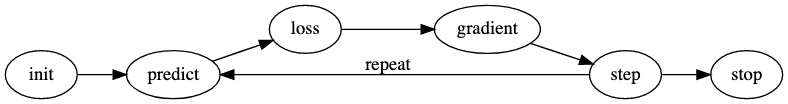

In [32]:
# lets start with an example
def f(x): return x**2

In [34]:
# we borrow the plot_function from the fastbook library
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

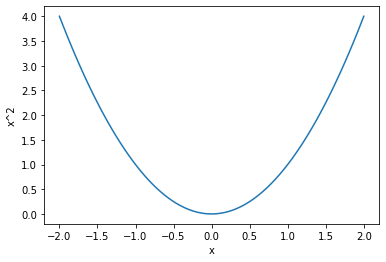

In [44]:
# and plot the function
plot_function(f, 'x', 'x^2')

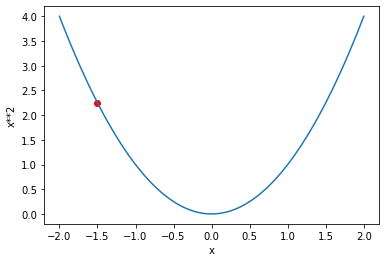

In [45]:
# weights are initialized randomly, so we pick a 'random' point
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

In [48]:
# calculating gradients with pytorch
xt = tensor(3.).requires_grad_()
xt

tensor(3., requires_grad=True)

In [49]:
# now apply our function from above
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [50]:
# and we let pytorch calculate the gradient via backprop
yt.backward()

In [53]:
xt.grad

tensor(6.)

This gives us 6 which is the same as 2\*3 (2x = df/dx)

In [54]:
# define tensor with .requires_grad_()
xt = tensor([3., 4., 10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [55]:
# define the function
def f(x): return (x**2).sum()

In [56]:
# apply the function
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [57]:
# propagate back
yt.backward()

In [58]:
# inspect the grad
xt.grad

tensor([ 6.,  8., 20.])

Remember the formula of gradient descent:

$ weights -= gradient(w) * lr$

#### Sidebar Gradient Descent - Rollercoaster Example

Imagine a rollercoaster driving over a hill..

In [60]:
# we sample in time steps
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

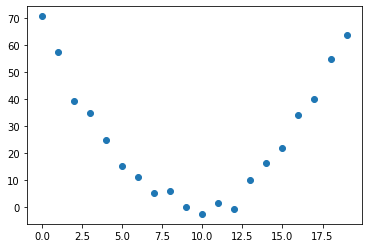

In [67]:
# fake some random speed measurement
speed = torch.randn(20) * 3 + .75*(time-9.5)**2 + 1
plt.scatter(time, speed);

Since it looks quadratic we only limit the solution space to quadratic functions where we need the variables $a$, $b$, $c$.

In [68]:
# create a quadratic function with input and params
def f(t, params):
    a, b, c = params
    return a*(t**2) + b*t + c

In [69]:
# now we also need a loss function
def mse(preds, targets): return ((preds-targets)**2).mean()

*Step 1: Initialize Parameters*

In [96]:
# we initialize our params randomly
params = torch.randn(3).requires_grad_()

In [97]:
# save our original params for later
orig_params = params.clone()

In [98]:
params, orig_params

(tensor([1.7335, 0.1604, 0.1088], requires_grad=True),
 tensor([1.7335, 0.1604, 0.1088], grad_fn=<CloneBackward>))

*Step 2: Calculate Predictions*

In [99]:
# calculate our predictions with our random weights
preds = f(time, params)

In [100]:
# create a function for comparing our predictions to our target
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

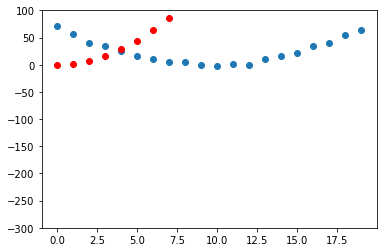

In [101]:
# display our first (random) try
show_preds(preds)

*Step 3: Calculate the Loss*

In [102]:
loss = mse(preds, speed)
loss

tensor(73993.4297, grad_fn=<MeanBackward0>)

*Step 4: Calculate the Gradients*

In [103]:
# we backpropagate the loss function and get the grad of our params
loss.backward()
params.grad

tensor([90841.2344,  5834.1602,   381.1667])

In [104]:
# initialize our learning rate
learning_rate = 1e-5

*Step 5: Step the Weights (Update)*

In [105]:
# we update the weights with the learning rate
params.data -= learning_rate * params.grad.data

# and reset the gradient
params.grad = None

In [106]:
# lets see if we have improved
preds = f(time, params)
mse(preds, speed)

tensor(14538.8691, grad_fn=<MeanBackward0>)

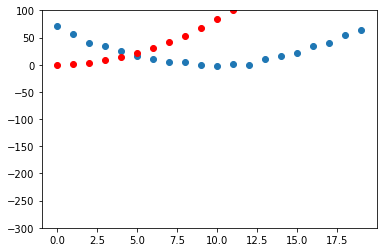

In [107]:
# lets see this improvement visually
show_preds(preds)

Thats is a little bit better but we need to do this step a lot more.

In [108]:
# create a function for automating our steps
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= learning_rate * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

*Step 6: Repeat the Process - aka Rinse & Repeat*

In [109]:
for i in range(10): apply_step(params)

14538.869140625
3288.24609375
1159.282470703125
756.4149169921875
680.1773681640625
665.7481079101562
663.0148315429688
662.4947509765625
662.3937377929688
662.3718872070312


In [110]:
# reset our params
params = orig_params.detach().requires_grad_()

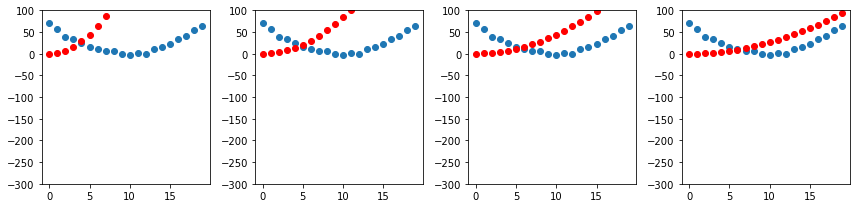

In [111]:
# lets see how this looks
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

*Step 8: Stop*

Usually we will stop if our loss is satisfying or we do not improve anymore.

#### End Sidebar

### The Loss Function

In [258]:
# because we have convolutions and no spatial concepts in
# our model we reshape the images from matrices to vectors
stacked_threes.shape

torch.Size([6131, 28, 28])

In [259]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

In [260]:
# create the labels for images
train_y = tensor([1]*len(threes) + [0]*len(sevens))
train_y

tensor([1, 1, 1,  ..., 0, 0, 0])

In [261]:
# create a matrix out of the vector
train_y = train_y.unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [262]:
# DataSet in PyTorch requires a tuple (x, y)
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [263]:
# do the same for our validation set
valid_x = torch.cat([valid_3_tensors, valid_7_tensors]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tensors) + [0]*len(valid_7_tensors)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [264]:
# create function with random data
def init_params(size, var=1.0): return (torch.randn(size) * var).requires_grad_()

In [265]:
# initialize our parameters
weights = init_params((28*28, 1))
bias = init_params(1)

In [266]:
# calculate the prediction for just one image
(train_x[0]*weights.T).sum() + bias

tensor([-14.1116], grad_fn=<AddBackward0>)

In [267]:
# create a linear function with matrix multiplication
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[-14.1116],
        [-17.0518],
        [-14.2547],
        ...,
        [ -3.5554],
        [-17.1609],
        [-11.9271]], grad_fn=<AddBackward0>)

In [268]:
# define a notion of accuracy
corrects =  (preds>bias.item()).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [269]:
# and calculate it
corrects.float().mean().item()

0.5070990920066833

In [270]:
# accuracy would not be a good loss function:

# slight change in weights
weights[0] *= 1.0001

# predict again
preds = linear1(train_x)
((preds>bias.item()).float() == train_y).float().mean().item()

0.5070990920066833

We would have the same loss because a small change in weights would not make a different prediction than before.

In [271]:
# we need a loss function that measures the distance
sample_target = tensor([1,0,1])
sample_predictions = tensor([.9, .4, .2])

In [278]:
# define a function which measures the distance to the supposed value
def mnist_loss(preds, targets):
    return torch.where(targets==1, 1-preds, preds).mean()

In [280]:
# example
torch.where(sample_target==1, 1-sample_predictions, sample_predictions)

tensor([0.1000, 0.4000, 0.8000])

In [276]:
# test function
mnist_loss(sample_predictions, sample_target)

tensor(0.5000)

### Sigmoid

In [283]:
# define sigmoid function
def sigmoid(x): return (1/(1+torch.exp(-x)))

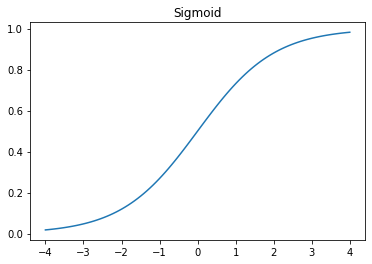

In [284]:
# but torch has its own
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [285]:
# with this smooshing we can refine our loss function
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(predictions==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [358]:
# batching with the dataloader
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([5, 9, 6, 3, 0]),
 tensor([10, 12,  1, 13,  2]),
 tensor([14, 11,  4,  8,  7])]

In [359]:
# but for the PyTorch DataLoader we need a dataset of (x, y) tuples
# we already loaded this
first(dset)[0].shape, first(dset)[1]

(torch.Size([784]), tensor([1]))

In [360]:
# remember the fastcore list on steroids!
L(enumerate(string.ascii_lowercase))

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

### Putting it all together

In [382]:
# re-initialize our parameters
weights = init_params((28*28, 1))
bias = init_params(1)

In [383]:
# create dataloader from our dataset
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [384]:
# same for the validation set
valid_dl = DataLoader(valid_dset, batch_size=256)

In [385]:
# test our functionality on a sample
test_batch = train_x[:4]
test_preds = linear1(test_batch)
print(test_preds)
loss = mnist_loss(test_preds, train_y[:4])
loss

tensor([[ -5.1510],
        [-13.8779],
        [ -4.6788],
        [  2.2561]], grad_fn=<AddBackward0>)


tensor(0.2300, grad_fn=<MeanBackward0>)

In [386]:
# calculate the gradients
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(0.0043), tensor([0.0252]))

In [387]:
# automate this with a function
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [388]:
calc_grad(test_batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(0.0086), tensor([0.0503]))

In [389]:
# do that a second time
calc_grad(test_batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(0.0129), tensor([0.0755]))

The gradient changed - because the backwards operation was added!

In [390]:
# combine everything into a function
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [391]:
(test_preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [ True]])

We were lucky with this one but don't be fooled by this result!

In [392]:
# verify with some more randomness
rand_idx = torch.randint(len(train_x), (1, 20)).squeeze(0)
rand_idx

tensor([ 3398,  1979,  9334,  7002,  4932,  3755,  3183,  2438, 10760,  8736,
         9150,  7287,  5325, 10107,  7662,  1939,  4384, 10537,  1291,  4014])

In [393]:
# this makes much more sense and is only like this
# because our bias is below the center
test_batch = train_x[rand_idx]
test_preds = linear1(test_batch)
loss = mnist_loss(test_preds, train_y[rand_idx])
loss

tensor(0.2818, grad_fn=<MeanBackward0>)

In [399]:
# create a function for calculating our batch accuracy
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [400]:
# test our function
batch_accuracy(test_preds, train_y[rand_idx])

tensor(0.1500)

In [404]:
# calculate the accuracy for all batches in one epoch
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

validate_epoch(linear1)

0.5068

Thats our starting point - quiet some room for improvement.

In [405]:
# train for one epoch and see how we do
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.5068

In [407]:
# and some more...
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 0.5068 